In [60]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from auxFunc import entropydensity
from scipy.special import kn, zeta


In [61]:
from sympy.parsing.mathematica import parse_mathematica
from sympy import var
x = var('x')
expr = "-(F[x]*G[x]^2) - 2*F[x]*G[x]*Yeq[x] - (F[x]*Yeq[x]^2)/(1 + F[x]*Yeq[x])^2 + (2*F[x]*G[x]*Yeq[x])/(1 + F[x]*Yeq[x]) + (2*F[x]*Yeq[x]^2)/(1 + F[x]*Yeq[x]) -  (Yeq[x]^2*Derivative[1][F][x])/(1 + F[x]*Yeq[x])^2 - Derivative[1][Yeq][x] - (F[x]*Yeq[x]*Derivative[1][Yeq][x])/(1 + F[x]*Yeq[x])^2 +  Derivative[1][Yeq][x]/(1 + F[x]*Yeq[x])"
expr = "-(F[x]*G[x]^2) - (2*F[x]^2*G[x]*Yeq[x]^2)/(1 + F[x]*Yeq[x]) + (F[x]*Yeq[x]^2*(1 + 2*F[x]*Yeq[x]))/(1 + F[x]*Yeq[x])^2 - (Yeq[x]^2*Derivative[1][F][x])/(1 + F[x]*Yeq[x])^2 + (-1 + (1 + F[x]*Yeq[x])^(-2))*Derivative[1][Yeq][x]"
expr = expr.replace('Derivative[1][F][x]','dFdx[x]').replace('Derivative[1][Yeq][x]','dYeqdx[x]')
python_code = parse_mathematica(expr)
# print(python_code)
python_simp = str(python_code).replace('F(x)*G(x)','fg').replace("/(F(x)*Yeq(x) + 1)","*t0").replace("Yeq(x)","yeq").replace("F(x)*yeq","fy")
print(python_simp)

(-1 + (fy + 1)**(-2))*dYeqdx(x) - fg**2 - 2*F(x)**2*G(x)*yeq**2*t0 + (2*fy + 1)*fy**2*t0**2 - yeq**2*dFdx(x)*t0**2


In [62]:
def Yeq(x):
    #m represents particle's mass, T is temperature in GeV, g represents the particle's degrees of freedom, 
    #and s represents entropy density.
    m = 1.0
    mDM = 1.0
    g = 1.0
    T = mDM/x
    xm = (m/mDM)*x

    g_star = 1.0 #g_* is the number of relativistic degrees of freedom
    s = (2.*np.pi**2/45.)*g_star*m**3/xm**3 #entropy density
    if xm > 10: #non-relativistic regime
        coeffs = [1,15./8.,105./128.,-315/1024.,10395./32768.]
        neq = (m**3*np.exp(-xm)/(xm**(3/2)))*(1/(2*np.sqrt(2)*np.pi**(3/2)))
        neq = neq*sum([c/xm**i for i,c in enumerate(coeffs)])
    elif xm > (2./3.): #semi-relativistic regime
        neq = m**3*(1/(2*np.pi**2))*kn(2, xm)/xm
    else: #relativistic regime
        neq = (zeta(3)/np.pi**2)*T**3 # bosons
        if g > 0:
           neq = (3/4)*neq # fermions
            
    Y_eq = abs(g)*neq/s
    
    return Y_eq


def F(x,l=100.0):

    return l**2/x**2

def dYeqdx(x):

    dx = 1e-4
    return (Yeq(x+dx)-Yeq(x))/dx

def dFdx(x):

    return (-2/x**3)*F(1)

def YtoG(Y,x):
    yeq = Yeq(x)
    f = F(x)
    fy = f*yeq
    t1 = fy/(1+fy)
    return Y - yeq*t1

def GtoY(G,x):
    yeq = Yeq(x)
    f = F(x)
    fy = f*yeq
    return G + yeq*(1-1/(1+fy))

def dYdx(Y,x):

    f = F(x)
    
    return f*(Yeq(x)**2 - Y**2)


In [63]:
def dGdx(G,x):

    f = F(x)
    yeq = Yeq(x)
    fy = f*yeq
    fg = f*G
    
    t0 = 1/(1+fy)
    
    d = -fg*G - 2*fy**2*G*t0 + yeq*fy*(1+2*fy)*t0**2 - dFdx(x)*(yeq*t0)**2 + dYeqdx(x)*(t0**2-1)

    return d

In [64]:
x0 = 0.1
Y0 = Yeq(x0)
G0 = YtoG(Y0,x0)
xvals = np.linspace(x0,100.,100)

print(Yeq(x0),F(x0),dYeqdx(x0),dFdx(x0),G0,dGdx(G0,x0))

0.2082424753736528 999999.9999999998 2.7755575615628914e-13 -19999999.999999996 9.99995197925596e-07 1.9999808965884954e-05


In [65]:
G_sol,gDict = odeint(dGdx,G0,xvals,full_output=True)
Y_sol0,yDict = odeint(dYdx,Y0,xvals,full_output=True)

In [66]:
Y_sol = [GtoY(G,x) for G,x in zip(G_sol,xvals)]
Y_eq = [Yeq(x) for x in xvals]
dGdx_sol = [dGdx(G,x) for G,x in zip(G_sol,xvals)]
dYdx_sol = [dYdx(Y,x) for Y,x in zip(Y_sol0,xvals)]

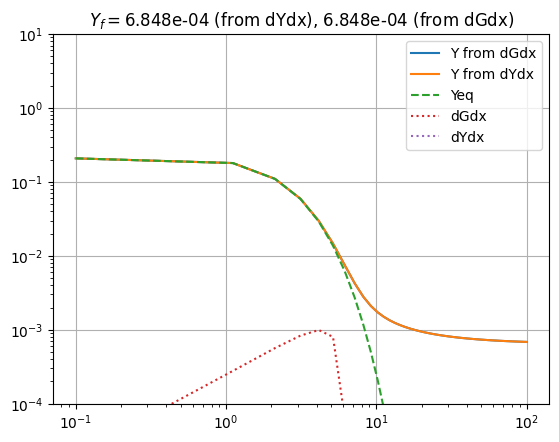

In [67]:
plt.plot(xvals,Y_sol,label='Y from dGdx')
plt.plot(xvals,Y_sol0,label='Y from dYdx')
plt.plot(xvals,Y_eq,linestyle='dashed',label='Yeq')
plt.plot(xvals,dGdx_sol,linestyle='dotted',label='dGdx')
plt.plot(xvals,dYdx_sol,linestyle='dotted',label='dYdx')

plt.legend()
plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-10,1e-1)
plt.ylim(1e-4,10)
plt.grid()
plt.title(r'$Y_{f} = $%1.3e (from dYdx), %1.3e (from dGdx)' %(Y_sol0[-1][0],Y_sol[-1][0]))
plt.show()

In [68]:
print(gDict['nst'].max(),yDict['nst'].max())
print(gDict['nfe'].max(),yDict['nfe'].max())
print(len(gDict['nst']),len(yDict['nst']))

305 371
692 764
99 99


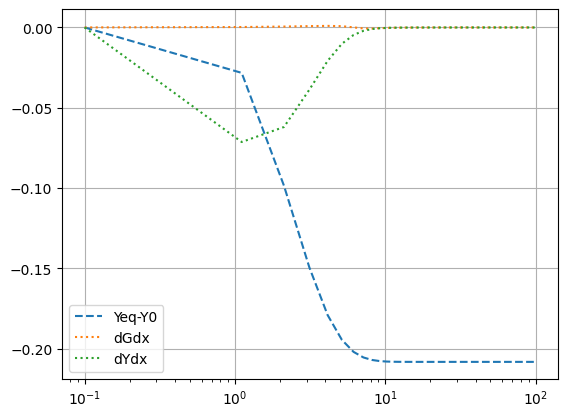

In [69]:
# plt.plot(xvals,Y_sol,label='Y from dGdx')
# plt.plot(xvals,Y_sol0,label='Y from dYdx')
plt.plot(xvals,Y_eq-Yeq(x0),linestyle='dashed',label='Yeq-Y0')
plt.plot(xvals,dGdx_sol,linestyle='dotted',label='dGdx')
plt.plot(xvals,dYdx_sol,linestyle='dotted',label='dYdx')

plt.legend()
# plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-10,1e-1)
# plt.ylim(1e-4,10)
# plt.ylim(-0.05,0.05)
plt.grid()
plt.show()

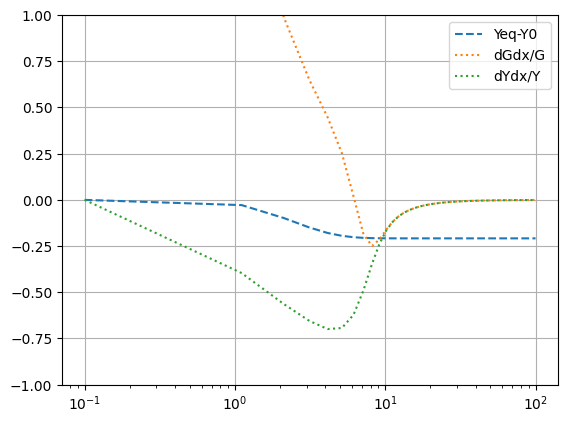

In [71]:
# plt.plot(xvals,Y_sol,label='Y from dGdx')
# plt.plot(xvals,Y_sol0,label='Y from dYdx')
plt.plot(xvals,Y_eq-Yeq(x0),linestyle='dashed',label='Yeq-Y0')
plt.plot(xvals,dGdx_sol/G_sol,linestyle='dotted',label='dGdx/G')
plt.plot(xvals,dYdx_sol/Y_sol0,linestyle='dotted',label='dYdx/Y')

plt.legend()
# plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-10,1e-1)
# plt.ylim(1e-4,10)
plt.ylim(-1,1)
plt.grid()
plt.show()